In [1]:
# Tải dữ liệu lên từ file matlab
import scipy.io as sio
import matplotlib.pylab as plt
import random
from PIL import Image
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

### Tải lên bộ data ảnh chữ số viết tay
Bộ dữ liệu gồm 5000 ảnh chữ số viết tay từ 0 đến 9, mỗi chữ số có 500 ảnh

In [2]:
data = sio.loadmat("data.mat")

# giá trị điểm ảnh của các chữ số viết tay từ 0 đến 9
# Gồm 5000 ảnh, mỗi ảnh có độ phân giải 20x20
X = data["X"]

# nhãn
y = data["y"]

y = y.reshape(len(y))
m, n = X.shape
m,n

(5000, 400)

### Hiển thị trực quan 100 mẫu trong bộ dữ liệu

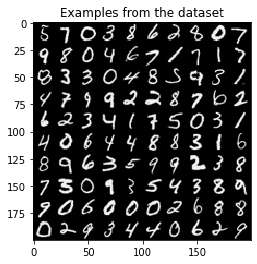

In [3]:
num_samples = 100
samples = random.sample(list(X), num_samples)
display_img = Image.new('RGB', (200, 200))

# Đưa 100 ảnh vào display_img
i = 0
for col in range(10):
    for row in range(10):
        array = samples[i]
        array = ((array / max(array)) * 255).reshape((20, 20)).transpose()
        img = Image.fromarray(array)
        display_img.paste(img, (col*20, row*20))
        i += 1

# Show ảnh
plt.title('Examples from the dataset')
plt.imshow(display_img, interpolation='nearest')

### Tái cấu trúc mảng numpy để thuận tiện cho tính toán

In [4]:
# vì data có 5000 ảnh, mỗi số là 500 ảnh được lưu theo thứ tự từ các ảnh số 0 đến các ảnh số 9
# ta có thể thay đổi kích thước ma trận nhằm nhóm các class cùng nhau vào cùng 1 chiều
# y(i,j) nhãn của ảnh thứ j lớp thứ i
y = y.reshape(10,500)

# X(i,j,k) data của ảnh thứ j lớp thứ i
X = X.reshape(10,500,400)

### Hiển thị trực quan hình ảnh 1 mẫu của dữ liệu

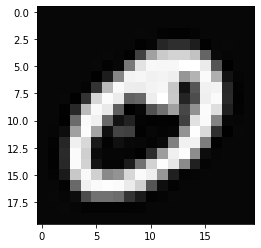

In [5]:
# Random data points
data = np.rollaxis(X[0,499].reshape(20,20),1)

# Plot the data using imshow with gray colormap
plt.imshow(data, cmap='gray')

# Display the plot
plt.show()

### Chia train test 
Mỗi chữ số từ 0 đến 9 sẽ có 400 ảnh train dùng để tính các đại lượng thống kê mẫu và 100 ảnh test để đánh giá, tổng cộng có 4000 mẫu train và 1000 mẫu test

In [6]:
# chia train test
# mỗi lớp có 500 ảnh, lấy 400 ảnh train, 100 ảnh test
X_train = X[:,:400,:]
X_test = X[:,400:,:]
y_train = y[:,:400]
y_test = y[:,400:]

### Tính sample mean
Tính giá trị trung bình của 400 điểm ảnh trên từng class chữ số

In [7]:
# tính sample mean
Mean = []
for i in range(len(X_train)):
    Mean.append(np.mean(X_train[i],axis=0))

### Tính sample covariance
Tính ma trận covariance của các điểm ảnh theo từng class chữ số

In [8]:
# tính sample covariance
Cov = []
for i in range(len(X_train)):
    Cov.append(np.cov(X_train[i].T))

### Hàm tính discriminant score

In [9]:
# hàm tính discriminant score, det và ma trận nghịch đạo ma trận covariance mỗi class được tính trước để giảm thời gian tính toán
def discriminant_score(x, Mean, log_prior_log_det_Cov, pinv_Cov):
    score = log_prior_log_det_Cov 
    score -= (1.0/2) * np.dot(np.dot((x - Mean).T, pinv_Cov),(x-Mean))   
    return score

### tính các đại lượng liên quan đến ma trận covariance cho mỗi class ngoài vòng lặp test để giảm thời gian tính toán

In [10]:
# tính trước det và ma trận nghịch đạo ma trận covariance mỗi class để giảm thời gian tính toán
det_Cov = []
pinv_Cov = []
log_prior = np.log(0.1)
for k in range(10):
    det_Cov.append(log_prior - (1.0/2) * np.log(np.linalg.det(Cov[k])+0.00000000001))
    pinv_Cov.append(np.linalg.pinv(Cov[k]))

### Thực hiện dự đoán các giá trị trong tập test
Đối với mỗi ảnh tập test, thực hiện tích discriminant score cho 10 lớp chỉ số, gán nhãn cho ảnh đó là nhãn có discriminant score lớn nhất

In [11]:
predict = []
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        dk = []
        for k in range(10):
            dk.append(discriminant_score(X_test[i,j], Mean[k], det_Cov[k], pinv_Cov[k]))
        max_value = max(dk)
        predict.append(dk.index(max_value))

In [12]:
y_test = y_test.reshape(-1)
y_test = np.where(y_test == 10, 0, y_test)

### Tính accuracy là tỉ lệ mẫu đúng trên tổng số mẫu

In [13]:
same = [x for x in range(len(predict)) if predict[x]==y_test[x]]
accuracy = len(same)/len(y_test)
accuracy

0.764

### Vẽ confusion matrix

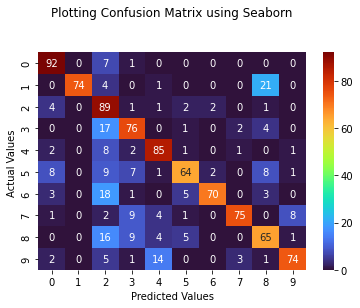

In [14]:
from sklearn import metrics
import seaborn as sebrn
confusion_matrix = metrics.confusion_matrix(y_test, predict)
# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(confusion_matrix, annot=True, cmap='turbo')

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');

plt.show()